# Project 2 - Finance

### DESCRIPTION

#### Problem Statement
- Finance Industry is the biggest consumer of Data Scientists. It faces constant attack by fraudsters, who try to trick the system. Correctly identifying fraudulent transactions is often compared with finding needle in a haystack because of the low event rate. 
- It is important that credit card companies are able to recognize fraudulent credit card transactions so that the customers are not charged for items that they did not purchase.
You are required to try various techniques such as supervised models with oversampling, unsupervised anomaly detection, and heuristics to get good accuracy at fraud detection.

#### Dataset Snapshot

The datasets contain transactions made by credit cards in September 2013 by European cardholders. This dataset represents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

### Project Task: Week 1

#### Exploratory Data Analysis (EDA):
- Perform an EDA on the Dataset.
      - Check all the latent features and parameters with their mean and standard deviation. Value are close to 0 centered (mean) with unit standard deviation
      - Find if there is any connection between Time, Amount, and the transaction being fraudulent.
- Check the class count for each class. It’s a class Imbalance problem.
- Use techniques like undersampling or oversampling before running Naïve Bayes, Logistic Regression or SVM.
       - Oversampling or undersampling can be used to tackle the class imbalance problem
       - Oversampling increases the prior probability of imbalanced class and in case of other classifiers, error gets multiplied as the low-proportionate class is mimicked multiple times.
- Following are the matrices for evaluating the model performance: Precision, Recall, F1-Score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this project.

In [1]:
# !pip install matplotlib
# !python -m pip install seaborn
# !pip install -U imbalanced-learn
# !pip install delayed
# !pip install xgboost

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import copy
import time
import sys
from datetime import datetime

from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [3]:
# read data
df_train_original = pd.read_csv('./dataset/train_data.csv')
df_test_original = pd.read_csv('./dataset/test_data_hidden.csv')
# df_test_original = pd.read_csv('./dataset/test_data.csv')

In [4]:
df_train = copy.deepcopy(df_train_original)
df_test = copy.deepcopy(df_test_original)

In [5]:
print(df_train.shape)
print(df_test.shape)

(227845, 31)
(56962, 31)


In [6]:
df_train.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,38355.0,1.043949,0.318555,1.045810,2.805989,-0.561113,-0.367956,0.032736,-0.042333,-0.322674,...,-0.240105,-0.680315,0.085328,0.684812,0.318620,-0.204963,0.001662,0.037894,49.67,0
1,22555.0,-1.665159,0.808440,1.805627,1.903416,-0.821627,0.934790,-0.824802,0.975890,1.747469,...,-0.335332,-0.510994,0.035839,0.147565,-0.529358,-0.566950,-0.595998,-0.220086,16.94,0
2,2431.0,-0.324096,0.601836,0.865329,-2.138000,0.294663,-1.251553,1.072114,-0.334896,1.071268,...,0.012220,0.352856,-0.341505,-0.145791,0.094194,-0.804026,0.229428,-0.021623,1.00,0
3,86773.0,-0.258270,1.217501,-0.585348,-0.875347,1.222481,-0.311027,1.073860,-0.161408,0.200665,...,-0.424626,-0.781158,0.019316,0.178614,-0.315616,0.096665,0.269740,-0.020635,10.78,0
4,127202.0,2.142162,-0.494988,-1.936511,-0.818288,-0.025213,-1.027245,-0.151627,-0.305750,-0.869482,...,0.010115,0.021722,0.079463,-0.480899,0.023846,-0.279076,-0.030121,-0.043888,39.96,0


In [7]:
df_test.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,113050.0,0.114697,0.796303,-0.149553,-0.823011,0.878763,-0.553152,0.939259,-0.108502,0.111137,...,-0.335776,-0.807853,-0.055940,-1.025281,-0.369557,0.204653,0.242724,0.085713,0.89,0
1,26667.0,-0.039318,0.495784,-0.810884,0.546693,1.986257,4.386342,-1.344891,-1.743736,-0.563103,...,-1.377003,-0.072200,-0.197573,1.014807,1.011293,-0.167684,0.113136,0.256836,85.00,0
2,159519.0,2.275706,-1.531508,-1.021969,-1.602152,-1.220329,-0.462376,-1.196485,-0.147058,-0.950224,...,-0.193271,-0.103533,0.150945,-0.811083,-0.197913,-0.128446,0.014197,-0.051289,42.70,0
3,137545.0,1.940137,-0.357671,-1.210551,0.382523,0.050823,-0.171322,-0.109124,-0.002115,0.869258,...,0.157994,0.650355,0.034206,0.739535,0.223605,-0.195509,-0.012791,-0.056841,29.99,0
4,63369.0,1.081395,-0.502615,1.075887,-0.543359,-1.472946,-1.065484,-0.443231,-0.143374,1.659826,...,0.224157,0.821209,-0.137223,0.986259,0.563228,-0.574206,0.089673,0.052036,68.00,0


In [8]:
# Rows containing train duplicate data
duplicate_rows_df_train = df_train[df_train.duplicated()]
print("number of duplicate train rows: ", duplicate_rows_df_train.shape)

number of duplicate train rows:  (745, 31)


In [9]:
# Rows containing test duplicate data
duplicate_rows_df_train = df_test[df_test.duplicated()]
print("number of duplicate test rows: ", duplicate_rows_df_train.shape)

number of duplicate test rows:  (46, 31)


In [10]:
# Remove duplicate entires
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

In [11]:
print(df_train.shape)
print(df_test.shape)

(227100, 31)
(56916, 31)


#### 1.a Check all the latent features and parameters with their mean and standard deviation. Value are close to 0 centered (mean)

In [12]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,227100.0,94746.494302,47495.251605,0.000000,54182.000000,84604.500000,139320.000000,172792.000000
V1,227100.0,0.001791,1.952816,-56.407510,-0.919384,0.015127,1.315237,2.454930
V2,227100.0,-0.005301,1.656315,-72.715728,-0.599724,0.064965,0.801545,22.057729
V3,227100.0,0.002509,1.508516,-32.965346,-0.888268,0.182346,1.029116,9.382558
V4,227100.0,-0.003076,1.413476,-5.683171,-0.850272,-0.021486,0.741161,16.875344
V5,227100.0,0.002376,1.363908,-42.147898,-0.689235,-0.054442,0.611081,34.801666
V6,227100.0,-0.000122,1.324954,-26.160506,-0.768359,-0.273776,0.398910,22.529298
V7,227100.0,0.001644,1.209975,-43.557242,-0.553775,0.040905,0.570641,36.877368
V8,227100.0,0.001277,1.175528,-73.216718,-0.207922,0.022600,0.326712,20.007208
V9,227100.0,-0.001757,1.094564,-13.434066,-0.644311,-0.052059,0.595705,15.594995


#### 1.b Find if there is any connection between Time, Amount, and the transaction being fraudulent.

C:\Users\iamka\anaconda3\envs\tfPractice\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Time ditributions'}, xlabel='Time', ylabel='Density'>

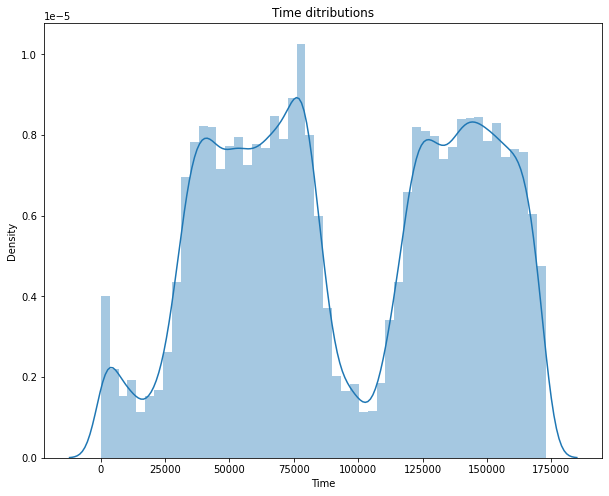

In [13]:
# visualizations of time
plt.figure(figsize=(10,8))
plt.title("Time ditributions")
sns.distplot(df_train.Time)

In [14]:
# The time inseconds need to converts
df_train['Time'] = df_train['Time'] / 3600
# df_train_original['Time'] = df_train_original['Time'] / 24
print(df_train['Time'].min())
print(df_train['Time'].max())

0.0
47.99777777777778


C:\Users\iamka\anaconda3\envs\tfPractice\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Transaction Times')

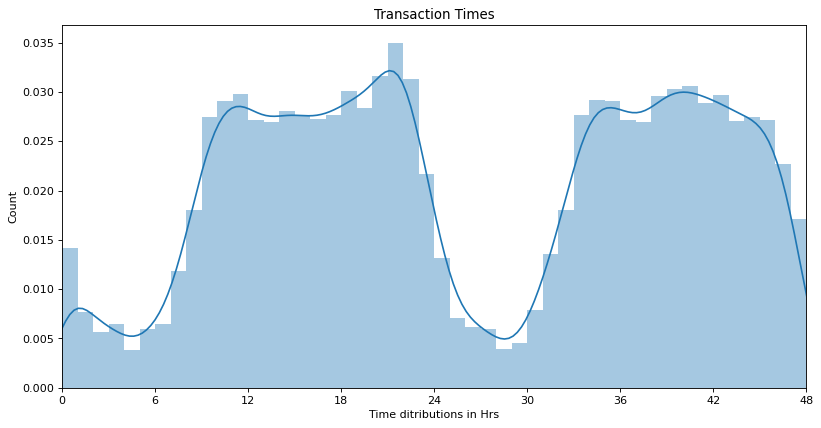

In [15]:
plt.figure(figsize=(12,6), dpi=80)
sns.distplot(df_train.Time, bins=48)
plt.xlim([0,48])
plt.xticks(np.arange(0,54,6))
plt.xlabel('Time ditributions in Hrs')
plt.ylabel('Count')
plt.title('Transaction Times')

C:\Users\iamka\anaconda3\envs\tfPractice\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Time ditributions'}, xlabel='Amount', ylabel='Density'>

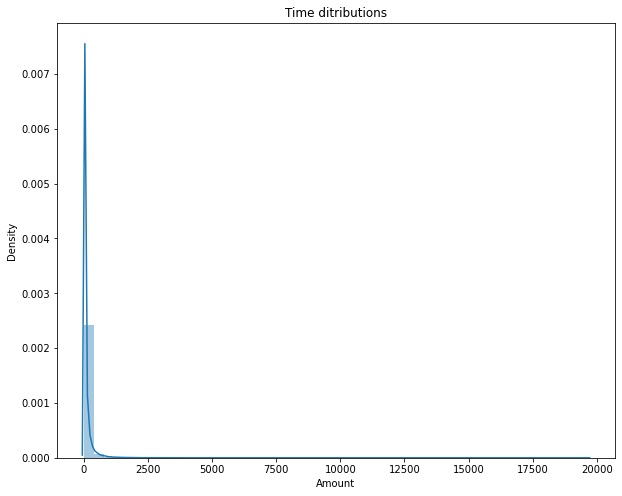

In [16]:
# visualizations of amount
plt.figure(figsize=(10,8))
plt.title("Time ditributions")
sns.distplot(df_train.Amount)

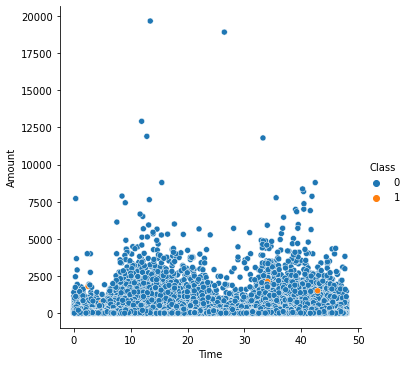

In [17]:
sns.relplot(x="Time", y="Amount", hue="Class", data=df_train);

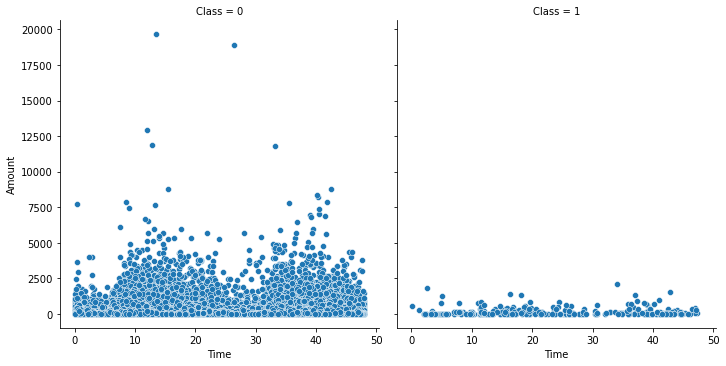

In [18]:
sns.relplot(x="Time", y="Amount", col="Class", data=df_train);

####   2.Check the class count for each class. It’s a class Imbalance problem.

In [19]:
df_train['Class'].value_counts()

0    226719
1       381
Name: Class, dtype: int64

C:\Users\iamka\anaconda3\envs\tfPractice\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Class', ylabel='count'>

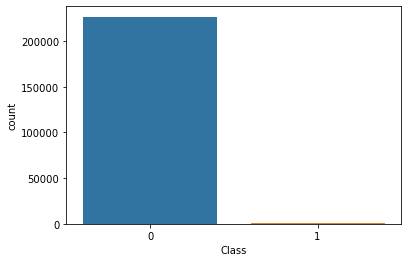

In [20]:
sns.countplot('Class', data=df_train)

#### 3.Use techniques like undersampling or oversampling before running Naïve Bayes, Logistic Regression or SVM.

In [21]:
robust_scaler = RobustScaler()

df_train['scaled_amount'] = robust_scaler.fit_transform(df_train['Amount'].values.reshape(-1,1))
df_train['scaled_time'] = robust_scaler.fit_transform(df_train['Time'].values.reshape(-1,1))

df_test['scaled_amount'] = robust_scaler.fit_transform(df_test['Amount'].values.reshape(-1,1))
df_test['scaled_time'] = robust_scaler.fit_transform(df_test['Time'].values.reshape(-1,1))

In [22]:
# Remove the Time,Amount 
df_train.drop(['Time','Amount'], axis=1, inplace=True)
df_test.drop(['Time','Amount'], axis=1, inplace=True)

In [23]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [24]:
y_train = df_train.pop('Class')
X_train = df_train

In [25]:
print(y_train.shape)
print(X_train.shape)

(227100,)
(227100, 30)


In [26]:
y_test = df_test.pop('Class')
X_test = df_test
print(X_test.shape)
print(y_test.shape)

(56916, 30)
(56916,)


In [27]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,227100.0,0.001791,1.952816,-56.407510,-0.919384,1.512736e-02,1.315237,2.454930
V2,227100.0,-0.005301,1.656315,-72.715728,-0.599724,6.496516e-02,0.801545,22.057729
V3,227100.0,0.002509,1.508516,-32.965346,-0.888268,1.823457e-01,1.029116,9.382558
V4,227100.0,-0.003076,1.413476,-5.683171,-0.850272,-2.148551e-02,0.741161,16.875344
V5,227100.0,0.002376,1.363908,-42.147898,-0.689235,-5.444162e-02,0.611081,34.801666
V6,227100.0,-0.000122,1.324954,-26.160506,-0.768359,-2.737758e-01,0.398910,22.529298
V7,227100.0,0.001644,1.209975,-43.557242,-0.553775,4.090522e-02,0.570641,36.877368
V8,227100.0,0.001277,1.175528,-73.216718,-0.207922,2.259952e-02,0.326712,20.007208
V9,227100.0,-0.001757,1.094564,-13.434066,-0.644311,-5.205855e-02,0.595705,15.594995
V10,227100.0,-0.002157,1.075832,-24.588262,-0.535715,-9.232904e-02,0.453780,23.745136


In [28]:
# oversampling tarin data
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

print(X_train_over.shape)
print(y_train_over.shape)

(453438, 30)
(453438,)


In [29]:
# undersampling tarin data
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

print(X_train_under.shape)
print(y_train_under.shape)

(762, 30)
(762,)


In [30]:
def modal_perfomance(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    predicted = model.predict(X_test)
    report = classification_report(Y_test, predicted)
    print("f1_score       : ", f1_score(Y_test, predicted, average="macro"))
    print("precision_score: ", precision_score(Y_test, predicted, average="macro"))
    print("recall_score   : ", recall_score(Y_test, predicted, average="macro"))
    print("\nAccuracy Score :",accuracy_score(predicted, Y_test))
    print(report)
    plot_roc_curve(model, X_test, Y_test)  
    plt.show() 
#     roc_curve_plt(model, X_test, Y_test, predicted)

C:\Users\iamka\anaconda3\envs\tfPractice\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


f1_score       :  0.5527717538690351
precision_score:  0.531255947382738
recall_score   :  0.9274674740183658

Accuracy Score : 0.9772120317661115
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56818
           1       0.06      0.88      0.12        98

    accuracy                           0.98     56916
   macro avg       0.53      0.93      0.55     56916
weighted avg       1.00      0.98      0.99     56916



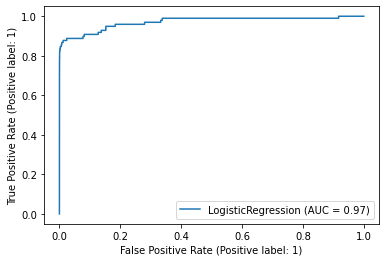

In [31]:
lr = LogisticRegression(class_weight ='balanced')
modal_perfomance(lr, X_train_over, y_train_over, X_test, y_test)

### Observations: Week 1
- Traing set contains two days transaction details, the rate transaction low at night times
- The amount of transcation is highy skewed distribution, only low number count detected for high amount transcation
- There is no connection between Time, Amount, and the transaction being fraudulent
- All the fraudulent transactions are low amount
- This is highly class Imbalance problem, fraudulent transaction are very rare less than 0.17 %

### Project Task: Week 2

#### Modeling Techniques:
- Try out models like Naive Bayes, Logistic Regression or SVM. Find out which one performs the best
- Use different Tree-based classifiers like Random Forest and XGBoost. 
       a.    Remember Tree-based classifiers work on two ideologies: Bagging or Boosting
       b.    Tree-based classifiers have fine-tuning parameters which takes care of the imbalanced class. Random-Forest and XGBboost.
- Compare the results of 1 with 2 and check if there is any incremental gain.

In [32]:
df_train = copy.deepcopy(df_train_original)
df_test = copy.deepcopy(df_test_original)

df_train.drop(['Time','Amount'], axis=1, inplace=True)
df_test.drop(['Time','Amount'], axis=1, inplace=True)
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

y_train = df_train.pop('Class')
X_train = df_train
y_test = df_test.pop('Class')
X_test = df_test

In [33]:
# Create logistic regression pipeline
lr_pipeline = Pipeline(
    steps=[
        ('scaler', StandardScaler()), 
        ('lr', LogisticRegression(n_jobs = -1, verbose=2))
    ]
)

In [34]:
# Create SVC pipeline
svm_pipeline = Pipeline(
    steps=[
        ('scaler', StandardScaler()), 
        ('svm', SVC(verbose=2))
    ]
)

In [35]:
# Create Gaussian NB pipeline
gnb_pipeline = Pipeline(
    steps=[
        ('scaler', StandardScaler()), 
        ('gnb', GaussianNB())
    ]
)

In [36]:
pipelines = [
    lr_pipeline, 
    svm_pipeline, 
    gnb_pipeline
]

In [37]:
pipeline_dict = {
    0 : 'LogisticRegression',
    1 : 'SVM',
    2 : 'Gaussian NB'
}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.3s finished


[LibSVM]

In [38]:
# finding best modal
for i,modal in enumerate(pipelines):
    print("{} Test accuracy {}".format(pipeline_dict[i], modal.score(X_test, y_test)))

LogisticRegression Test accuracy 0.9991924440855307
SVM Test accuracy 0.9992977774656788
Gaussian NB Test accuracy 0.9780906569291808


In [39]:
def tree_perfomace_tracker(modal, X_test, y_test ):
    predict = modal.predict(X_test)
    cf_matrix = confusion_matrix(predict, y_test)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='')

    print("Accuracy Score :",accuracy_score(predict, y_test))
    print("f1_score       : ", f1_score(predict, y_test))
    

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


Accuracy Score : 0.9995259997893332
f1_score       :  0.8457142857142858


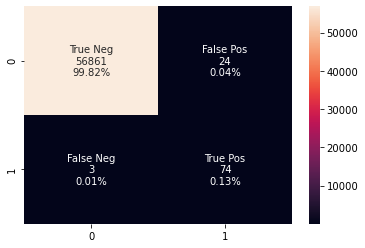

In [40]:
# RAndom Forest
rf = RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
tree_perfomace_tracker(rf, X_test, y_test)

C:\Users\iamka\anaconda3\envs\tfPractice\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy Score : 0.9993679997191109
f1_score       :  0.8


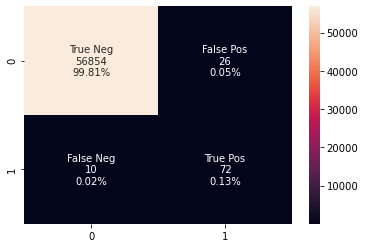

In [41]:
# Xg Boost
xb = xgb.XGBClassifier(learning_rate=0.001, n_jobs=-1)
xb.fit(X_train, y_train, eval_metric='logloss', verbose=True)
tree_perfomace_tracker(xb, X_test, y_test)

Accuracy Score : 0.9993153330290369
f1_score       :  0.7547169811320755


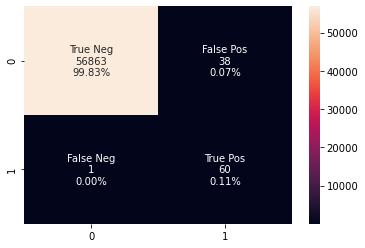

In [42]:
# Bagging Classifire
BC_clf = BaggingClassifier(base_estimator=SVC(), random_state=0, n_jobs=-1)
BC_clf.fit(X_train, y_train)
tree_perfomace_tracker(BC_clf, X_test, y_test)

Accuracy Score : 0.9994733330992591
f1_score       :  0.8255813953488371


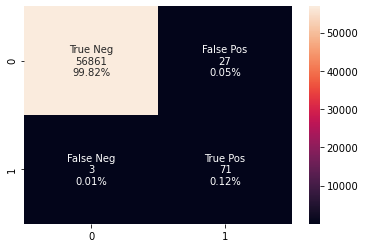

In [43]:
# Bagging Classifire
BC_RFC = BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced_subsample'),  n_jobs=-1)
BC_RFC.fit(X_train, y_train)
tree_perfomace_tracker(BC_RFC, X_test, y_test)

Accuracy Score : 0.9992626663389628
f1_score       :  0.746987951807229


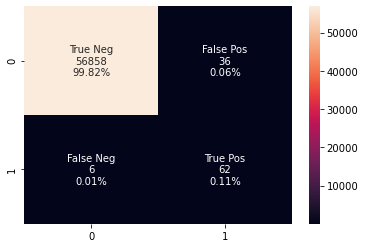

In [44]:
# Gradient Classifire
GBC = GradientBoostingClassifier(random_state=0, loss='deviance', learning_rate=0.01, criterion='mse')
GBC.fit(X_train, y_train)
tree_perfomace_tracker(GBC,  X_test, y_test)

Accuracy Score : 0.9994908886626171
f1_score       :  0.8284023668639053


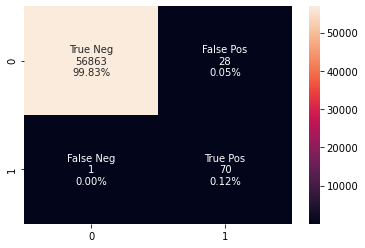

In [45]:
# Extra Classifire
ETC = ExtraTreesClassifier(n_estimators=100, random_state=0, class_weight='balanced', n_jobs = 6)
ETC.fit(X_train, y_train)
tree_perfomace_tracker(ETC, X_test, y_test)

Accuracy Score : 0.9992099996488887
f1_score       :  0.7513812154696133


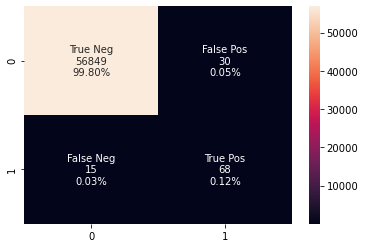

In [46]:
# Ada boost Classifire
ADC = AdaBoostClassifier(n_estimators=100, random_state=0)
ADC.fit(X_train, y_train)
tree_perfomace_tracker(ADC, X_test, y_test)

### Observations: Week 2


### Project Task: Week 3

#### Applying ANN:
- Use ANN (Artificial Neural Network) to identify fradulent and non-fradulent.
       a)    Fine-tune number of layers
       b)    Number of Neurons in each layers
       c)    Experiment in batch-size
       d)    Experiment with number of epochs. Check the observations in loss and accuracy
       e)    Play with different Learning Rate variants of Gradient Descent like Adam, SGD, RMS-prop
       f)    Find out which activation performs best for this use case and why?
       g)    Check Confusion Matrix, Precision, Recall and F1-Score
- Try out Dropout for ANN. How is it performed? Compare model performance with the traditional ML based prediction models from above. 
- Find the best setting of neural net that can be best classified as fraudulent and non-fraudulent transactions. Use techniques like Grid Search, Cross-Validation and Random search.

##### Anomaly Detection:
- Implement anomaly detection algorithms.
        a)    Assume that the data is coming from a single or a combination of multivariate Gaussian
        b)    Formalize a scoring criterion, which gives a scoring probability for the given data point whether it belongs to the multivariate Gaussian or Normal Distribution fitted in a)

In [47]:
df_train.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,1.043949,0.318555,1.045810,2.805989,-0.561113,-0.367956,0.032736,-0.042333,-0.322674,0.499167,...,-0.720944,-0.084556,-0.240105,-0.680315,0.085328,0.684812,0.318620,-0.204963,0.001662,0.037894
1,-1.665159,0.808440,1.805627,1.903416,-0.821627,0.934790,-0.824802,0.975890,1.747469,-0.658751,...,1.325588,-0.373759,-0.335332,-0.510994,0.035839,0.147565,-0.529358,-0.566950,-0.595998,-0.220086
2,-0.324096,0.601836,0.865329,-2.138000,0.294663,-1.251553,1.072114,-0.334896,1.071268,-1.109522,...,0.095583,-0.039868,0.012220,0.352856,-0.341505,-0.145791,0.094194,-0.804026,0.229428,-0.021623
3,-0.258270,1.217501,-0.585348,-0.875347,1.222481,-0.311027,1.073860,-0.161408,0.200665,0.154307,...,0.136148,0.382305,-0.424626,-0.781158,0.019316,0.178614,-0.315616,0.096665,0.269740,-0.020635
4,2.142162,-0.494988,-1.936511,-0.818288,-0.025213,-1.027245,-0.151627,-0.305750,-0.869482,0.428729,...,1.064984,0.106592,0.010115,0.021722,0.079463,-0.480899,0.023846,-0.279076,-0.030121,-0.043888


In [48]:
def model_building(optimizer='Adam', learn_rate = 0.01, dropout_rate = 0.2):
    model = Sequential()
    model.add(Dense(input_dim = 28, units = 256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(units =  512 , activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 114, activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 56, activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units =1, activation = 'sigmoid'))    
    
    model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC()])
    return model

In [49]:
model_building().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7424      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 114)               2

In [50]:
# tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model_building().compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
# print(os.getcwd())
logdir="logs/fit/"+ datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history = model_building().fit(X_train, y_train, epochs=10, batch_size=45, validation_data=(X_test, y_test))

Epoch 1/10
5064/5064 [==============================] - 34s 7ms/step - loss: 0.0069 - accuracy: 0.9989 - auc_2: 0.9127 - val_loss: 0.0059 - val_accuracy: 0.9994 - val_auc_2: 0.9223
Epoch 2/10
5064/5064 [==============================] - 31s 6ms/step - loss: 0.0066 - accuracy: 0.9991 - auc_2: 0.9247 - val_loss: 0.0044 - val_accuracy: 0.9993 - val_auc_2: 0.9325
Epoch 3/10
5064/5064 [==============================] - 31s 6ms/step - loss: 0.0053 - accuracy: 0.9992 - auc_2: 0.9314 - val_loss: 0.0111 - val_accuracy: 0.9993 - val_auc_2: 0.8825
Epoch 4/10
5064/5064 [==============================] - 30s 6ms/step - loss: 0.0062 - accuracy: 0.9992 - auc_2: 0.9364 - val_loss: 0.0073 - val_accuracy: 0.9993 - val_auc_2: 0.9130
Epoch 5/10
5064/5064 [==============================] - 36s 7ms/step - loss: 0.0057 - accuracy: 0.9991 - auc_2: 0.9325 - val_loss: 0.0060 - val_accuracy: 0.9993 - val_auc_2: 0.9429
Epoch 6/10
5064/5064 [==============================] - 33s 6ms/step - loss: 0.0049 - accuracy:

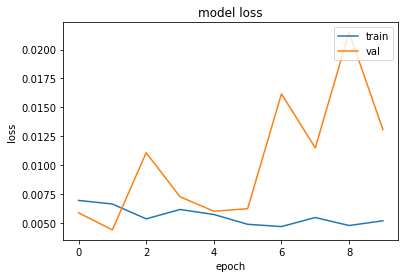

In [52]:
# Experiment with number of epochs. Check the observations in loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

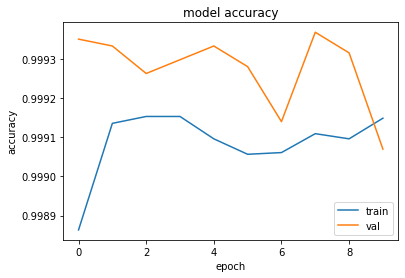

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [54]:
ann_modal = KerasClassifier(build_fn=model_building, epochs=30)
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
learn_rate = [0.01, 0.02, 0.2]
dropout_rate = [0.0, 0.1, 0.2, 0.4]
param_grid = dict(batch_size=batch_size, epochs=epochs,learn_rate=learn_rate, dropout_rate=dropout_rate)

#### RandamSearch

In [ ]:
grid = RandomizedSearchCV(estimator=ann_modal, param_distributions =param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))

In [ ]:
print("\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#### Cross-Validation

In [ ]:
scores = cross_val_score(ann_modal, X_train, y_train, cv=5, scoring='f1')
print("f1 score is: ", scores.mean())

In [ ]:
# Experiment in batch-size
batch_size = [10, 20, 40, 60, 80, 100]
param_grid = dict(batch_size = batch_size)
grid = GridSearchCV(estimator = ann_modal, param_grid = param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train,y_train,validation_data=(X_test, y_test))
print("\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
#  Play with different Learning Rate variants of Gradient Descent like Adam, SGD, RMS-prop
optimizers = ['SGD', 'RMSprop', 'Adam']
param_grid = dict(optimizer=optimizers)
grid = GridSearchCV(estimator = ann_modal, param_grid = param_grid, n_jobs = -1, cv = 3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))
print("Best optimizers With Best score: ",grid_result.best_score_, grid_result.best_params_)

#### Perfomace Evalution

In [ ]:
# ann_predictions = model_building().predict(X_test)
ann_predictions = model_building().predict(X_test, verbose=0)
yhat_classes = model_building().predict_classes(X_test, verbose=0)
yhat_probs = ann_predictions[:, 0]
yhat_classes = yhat_classes[:, 0]

accuracy = accuracy_score(y_test, yhat_classes)
f1 = f1_score(y_test, yhat_classes)

cm = tf.math.confusion_matrix(labels=y_test, predictions=ann_predictions, num_classes=2)
sns.heatmap(cm, annot=True)

print("Accuracy Score :", accuracy)
print("f1_score       : ", f1)

#### Anomaly Detection:

In [ ]:
df_train = copy.deepcopy(df_train_original)
df_test = copy.deepcopy(df_test_original)

fraud = df_train[df_train['Class'] == 1]
valid = df_train[df_train['Class'] == 0]
outlier_fraction = len(fraud) / float(len(valid))
n_outliers = len(fraud)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

y_train = df_train.pop('Class')
X_train = df_train

In [ ]:

classifiers = {
    "Isolation Forest" : IsolationForest(
        n_estimators = 100, 
        max_samples = len(X_train), 
        contamination = outlier_fraction,
        random_state = 1, 
        verbose = 1,
        n_jobs = -1
    ),
    "Local Outlier Factor" : LocalOutlierFactor(
        n_neighbors=20, 
        algorithm='auto', 
        leaf_size=30, 
        metric='minkowski',
        p=2, metric_params = None, 
        contamination = outlier_fraction,
        n_jobs = -1
    )   
}

In [ ]:

for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_train)
        scores_prediction = clf.negative_outlier_factor_
    else:    
        clf.fit(X_train)
        scores_prediction = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y_train).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name, n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y_train, y_pred))
    print("Classification Report :")
    print(classification_report(y_train, y_pred))